# URL clustering based on similarity

# Imports & Helper functions

## Save or load jupyter session

## Imports

In [1]:
import multiprocessing as mp
import pickle
import time
import warnings
from collections import Counter
from math import log

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import psutil
import scipy.sparse as sp
import seaborn as sns
import smaz
import tldextract
from sklearn.cluster import Birch
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

sns.set()

/home/xsevcik9/jupyter-base/avast_thesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocessing functions

In [2]:
def load_data(file_path):
    """
    Load input data
    """

    return pd.read_csv(
        file_path,
        delimiter=",",
        dtype={"url": "string"},
        usecols=["url"],
    )

## Non TF-IDF

### Data extraction & cleaning

#### Extract Fully Qualified Domain Names (FQDNs) from URLs

In [3]:
def extract_FQDNs(df):
    """
    Extract FQDNs from URLs
    """

    df = df.copy()

    # Regex pattern to extract fully qualified domain name (FQDN)
    pattern = r"(?:.*?:\/\/)?(?P<www>[wW]{3}\.)?(?P<domain>[\w\.\-]+)[^\w]*"

    # Execute regex over URLs
    match = df["url"].str.extract(pattern)

    # Extract domain using named group
    df["FQDN"] = match["domain"]

    return df

#### Remove all FQDN duplicates and addreses IPv4 addresses

IPv6 are cleaned further down in `clean_invalid_domains(df)` function.

In [4]:
def clean_data(df):
    """
    Clean data of FQDN duplicates and IPv4 addresses
    """

    df = df.copy()

    # Pattern that matches all IPv4 addresses
    pattern = "(?:.*?:\/\/)?(?P<www>[wW]{3}\.)?[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}([/:].*)?$"

    # Leave only data not containing pure IPv4
    df = df[~df["url"].str.match(pattern)]

    # Remove all data with non-unique FQDN
    df = df.drop_duplicates(subset="FQDN")

    # Reset index
    df = df.reset_index(drop=True)

    return df

#### Separate TLD, domain and subdomain

In [5]:
def extract_url_components(url):
    """
    Extract relevant components of FQDN from URL using tldextract
        Get information about validity of FQDN through suffix and tldextract (using The Public Suffix List)
    """
    
    ext = tldextract.extract(url)
    return pd.Series(
        [
            ext.subdomain,
            ext.domain,
            ext.suffix,
            ext.suffix == "",
            ext.domain + "." + ext.suffix,
        ]
    )

In [6]:
def expand_urls(df):
    """
    Get individual components of FQDNs from URLs
    """

    df = df.copy()

    # Apply function to url column to extract domain components and explode into separate columns
    df[["subdomain", "domain", "TLD", "is_invalid_TLD", "domainTLD"]] = df["url"].apply(
        extract_url_components
    )

    return df

In [7]:
def clean_invalid_domains(df):
    """
    Remove all FQDNs with invalid TLD (ie. TLD not in Public Suffix List)
    """

    df = df.copy()

    # Remove domains with invalid TLD
    df = df[~df["is_invalid_TLD"]]

    # Remove unused is_invalid_TLD
    df = df.drop("is_invalid_TLD", axis=1)

    # Reset index
    df = df.reset_index(drop=True)

    return df

#### Length of domain, subdomain and TLD

In [8]:
def extract_lengths(df):
    """
    Extract lengths of individual FQDN components
    """

    df = df.copy()

    df[["domain_length", "subdomain_length", "TLD_length"]] = df[
        ["domain", "subdomain", "TLD"]
    ].applymap(len)

    return df

#### Number of subdomains

I decided to include www in the count of subdomains.

In [9]:
def extract_subdomains_count(df):
    """
    Extract number of subdomains (excluding Second-Level domain)
    """
    
    df = df.copy()

    df["num_of_subdomains"] = (
        df["subdomain"].str.split(".").apply(lambda x: len(x) if x != [""] else 0)
    )

    return df

#### Characters frequency & vowel-to-consonant ratio
Characters:
- alphabetical - "a-zA-Z"
- digits - "0-9"
- special - all except alphabetical, digits and dot

In [10]:
def extract_char_frequency_vowel_consonant_ratio(df):
    """
    Extract frequencies of character groups for each individual FQDN component
    """

    df = df.copy()

    for column in ["domain", "subdomain", "TLD"]:
        # Vowel-to-consonant ratio
        vowel_counts = df[column].str.count(r"[aeiouAEIOU]")
        consonant_counts = df[column].str.count(r"[b-df-hj-np-tv-zB-DF-HJ-NP-TV-Z]")

        # Get alphabetical, numeric and special character counts for specific column
        numeric_counts = df[column].str.count(r"[0-9]")
        special_counts = df[column].str.count(r"[^A-Za-z0-9\s\.]")
        alpha_counts = vowel_counts + consonant_counts

        # Add them into DF
        df[
            [
                f"{column}_alpha_count",
                f"{column}_numeric_count",
                f"{column}_special_count",
                f"{column}_vowel_consonant_ratio",
            ]
        ] = pd.Series(
            [
                alpha_counts,
                numeric_counts,
                special_counts,
                vowel_counts / consonant_counts,
            ]
        )

    return df

#### Complexity of domain and subdomain

Using compression algorithm (`smaz` python implementation) to approximate Kolmogorov complexity

In [11]:
def approximate_kolmogorov_complexity(df):
    """
    Approximate the Kolmogorov complexity of the 'FQDN' column in a DataFrame
    """
    
    df = df.copy()

    # Calculate the ratio of the length of the compressed string to the length of the original string
    # This ratio is used as an approximation of the Kolmogorov complexity
    df[["FQDN_complexity"]] = df[["FQDN"]].applymap(
        lambda s: len(smaz.compress(s)) / len(s) if s != "" else np.nan
    )

    return df

#### Feature imputation, scaling & selection

In [12]:
def impute_values(df):
    """
    Impute data for PCA application
    """

    df = df.copy()

    # Replace NaN values with zeros
    df.fillna(0, inplace=True)

    # Replace infinities with the maximum finite value in each column
    df = df.replace([np.inf, -np.inf], np.nan)
    max_values = df.max()

    df.fillna(max_values, inplace=True)

    return df

In [13]:
def slice_dataset(df, columns_to_take):
    """
    Extract specified columns
    """

    df = df.copy()

    df = df.loc[:, columns_to_take]

    return df

In [14]:
def standardise_features(df):
    """
    Standardise all features in df
    """

    ssc = StandardScaler()

    matrix = ssc.fit_transform(df)

    return matrix

In [15]:
def select_features(matrix, random_state=None):
    """
    Select best features from given matrix using PCA
    """

    pca = PCA(n_components=0.95, random_state=random_state)
    matrix = pca.fit_transform(matrix)

    return matrix

In [16]:
def extract_features(df):
    """
    Extract all features from URLs
    """

    df = df.copy()
    df = extract_FQDNs(df)
    df = clean_data(df)
    df = expand_urls(df)
    df = clean_invalid_domains(df)
    df = extract_lengths(df)
    df = extract_subdomains_count(df)
    df = extract_char_frequency_vowel_consonant_ratio(df)
    df = approximate_kolmogorov_complexity(df)

    return df

In [17]:
# Set all numeric features usable for PCA
numeric_columns = [
    "domain_length",
    "subdomain_length",
    "TLD_length",
    "num_of_subdomains",
    "domain_alpha_count",
    "domain_numeric_count",
    "domain_special_count",
    "domain_vowel_consonant_ratio",
    "subdomain_alpha_count",
    "subdomain_numeric_count",
    "subdomain_special_count",
    "subdomain_vowel_consonant_ratio",
    "TLD_alpha_count",
    "TLD_numeric_count",
    "TLD_special_count",
    "TLD_vowel_consonant_ratio",
    "FQDN_complexity",
]


def transform_features(df, numeric_columns=numeric_columns, random_state=None):
    """
    Transform non-TF-IDF (non-sparse) features for BIRCH
    """

    df = df.copy()

    df = impute_values(df)
    df = slice_dataset(df, numeric_columns)

    # From here data is in np.ndarray
    matrix = standardise_features(df)
    matrix = select_features(matrix, random_state)

    return matrix

## TF-IDF

### Incremental wrapper

In [18]:
class IncrementalTfidf:
    """
    A class to process text data in chunks and incrementally compute character-level TF-IDF values.

    Attributes:
    -----------
    hashing_vectoriser : HashingVectorizer
        Vectoriser that converts text data to a term-document matrix using the hashing trick
    tfidf_transformer : TfidfTransformer
        Transformer that computes TF-IDF values from the term-document matrix
    X_counts : scipy.sparse matrix
        Accumulated term-document matrix
    X_tfidf : scipy.sparse matrix
        Accumulated TF-IDF representation
    """

    def __init__(
        self,
        ngram_range=(1, 1),
        n_features=2**20,
        column_name="",
    ):
        """
        Initialize the IncrementalTfidf with a HashingVectorizer and TfidfTransformer.
        """
        
        self.hashing_vectoriser = HashingVectorizer(
            analyzer="char",
            token_pattern=None,
            n_features=n_features,
            ngram_range=ngram_range,
        )
        self.tfidf_transformer = TfidfTransformer()
        self.X_counts = None
        self.X_tfidf = None
        self.column_name = column_name

    def update_tf_counts(self, chunk):
        """
        Update the term-document matrix with the new chunk of text data.

        Parameters:
        -----------
        chunk : pandas.Series or list of str
            New chunk of text data
        """
        # Transform the chunk of text data into a term-document matrix using the HashingVectorizer
        chunk_counts = self.hashing_vectoriser.transform(chunk)

        # If this is the first chunk, set the term-document matrix to the transformed chunk
        if self.X_counts is None:
            self.X_counts = chunk_counts
        else:
            # Otherwise, stack the transformed chunk to the existing term-document matrix
            self.X_counts = sp.vstack((self.X_counts, chunk_counts))

    def update_idf(self):
        """
        Update the TfidfTransformer based on the current term-document matrix.
        """
        self.tfidf_transformer.fit(self.X_counts)

    def partial_fit(self, chunk):
        """
        Update the term-document matrix and fits the TfidfTransformer with the new chunk of text data.

        Parameters:
        -----------
        chunk : pandas.Series or list of str
            New chunk of text data

        Returns:
        --------
        self : IncrementalTfidf
            The instance of the IncrementalTfidf
        """
        
        self.update_tf_counts(chunk)
        self.update_idf()
        return self

    def transform(self, chunk):
        """
        Transform the given chunk of text data to a TF-IDF representation.

        Parameters:
        -----------
        chunk : pandas.Series or list of str
            Chunk of text data to be transformed

        Returns:
        --------
        chunk_tfidf : scipy.sparse matrix
            Transformed chunk in TF-IDF representation
        """
        
        chunk_counts = self.hashing_vectoriser.transform(chunk)
        chunk_tfidf = self.tfidf_transformer.transform(chunk_counts)
        return chunk_tfidf

    def partial_fit_transform(self, chunk):
        """
        Update the term-document matrix, fit the TfidfTransformer, and transform the given chunk of text data.

        Parameters:
        -----------
        chunk : pandas.Series or list of str
            New chunk of text data

        Returns:
        --------
        chunk_tfidf : scipy.sparse matrix
            Transformed chunk in TF-IDF representation
        """
        
        self.partial_fit(chunk)
        return self.transform(chunk)

    def compute_tfidf(self):
        """
        Retrieve the accumulated TF-IDF representation of the processed text data.

        Returns:
        --------
        X_tfidf : scipy.sparse matrix
            Accumulated TF-IDF representation
        """
        self.X_tfidf = self.tfidf_transformer.transform(self.X_counts)
        return self.X_tfidf

### TF-IDF Transformation

In [19]:
def fit_vectorisers(df, columns, ngram_ranges):
    """
    Create TF-IDF vectorisers and fits them to specified columns
    """
    
    fitted_tfidf_vectorisers = []

    for i, column in enumerate(columns):
        incremental_tfidf = IncrementalTfidf(
            ngram_range=ngram_ranges[i], column_name=column
        )

        incremental_tfidf.partial_fit(df[column])

        fitted_tfidf_vectorisers.append(incremental_tfidf)

    return fitted_tfidf_vectorisers

In [20]:
def increment_fit_vectorisers(df, fitted_vectorisers):
    """
    Update TF-IDF vectorisers incrementally
    """
    
    for vectoriser in fitted_vectorisers:
        vectoriser.partial_fit(df[vectoriser.column_name])

    return fitted_vectorisers

In [21]:
def get_tfidf_matrices(fitted_vectorisers):
    """
    Retrieve TF-IDF matrices from fitted vectorisers
    """
    
    return [
        incremental_tfidf.compute_tfidf() for incremental_tfidf in fitted_vectorisers
    ]

### TF-IDF feature selection

In [22]:
def lsa_selection(tfidf_matrices, n_components, random_state):
    """
    Perform Latent Semantic Analysis (LSA) on a list of TF-IDF matrices
    """

    # Initialize lists to store the selected LSA-transformed TF-IDF matrices and their explained variances
    selected_matrices = []
    explained_variances = []

    # Loop through each TF-IDF matrix
    for i, tfidf_matrix in enumerate(tfidf_matrices):
        # Perform LSA on the TF-IDF matrix
        lsa = TruncatedSVD(n_components=n_components[i], random_state=random_state)

        X_lsa = lsa.fit_transform(tfidf_matrix)

        # Add the LSA-transformed TF-IDF matrix and its explained variance to their respective lists
        selected_matrices.append(X_lsa)
        explained_variances.append(lsa.explained_variance_ratio_.sum())

    # Return the selected LSA-transformed TF-IDF matrices and their explained variances
    return (selected_matrices, explained_variances)

### TF-IDF preprocessing

In [23]:
def preprocess_tfidf(df, columns, ngram_ranges, n_components, random_state=None):
    """
    Preprocess data using TF-IDF vectorisation and Latent Semantic Analysis (LSA)
    """

    # Fit the TF-IDF vectorisers to the data in the specified columns and ngram ranges
    fitted_vectorisers = fit_vectorisers(df, columns, ngram_ranges)

    # Get the TF-IDF matrices from the fitted vectorisers
    tfidf_matrices = get_tfidf_matrices(fitted_vectorisers)

    # Perform LSA on the TF-IDF matrices
    tfidf_lsas, explained_variances = lsa_selection(
        tfidf_matrices, n_components, random_state
    )

    # Return the LSA-transformed TF-IDF matrices, their explained variances, and the fitted vectorisers
    return tfidf_lsas, explained_variances, fitted_vectorisers

In [24]:
def increment_preprocess_tfidf(df, n_components, fitted_vectorisers, random_state=None):
    """
    Incrementally update fitted TF-IDF vectorisers and perform Latent Semantic Analysis (LSA)
    """

    # Update the TF-IDF vectorisers with a data chunk
    inc_fitted_vectorisers = increment_fit_vectorisers(df, fitted_vectorisers)

    # Get updated TF-IDF matrices from the updated vectorisers
    tfidf_matrices = get_tfidf_matrices(inc_fitted_vectorisers)

    # Perform LSA on updated TF-IDF matrices
    tfidf_lsas, explained_variances = lsa_selection(
        tfidf_matrices, n_components, random_state
    )

    # Return the LSA-transformed TF-IDF matrices, their explained variances, and the updated vectorisers
    return tfidf_lsas, explained_variances, inc_fitted_vectorisers

# Model training & Evaluation functions

In [25]:
def subsample(X, sample_size, seed, labels=None):
    """
    Take random sample from X
    """

    np.random.seed(seed)

    random_indices = np.random.choice(X.shape[0], size=sample_size, replace=False)

    X_subsample = X[random_indices]

    labels_subsample = None

    if labels is not None:
        labels_subsample = labels[random_indices]

    return (X_subsample, labels_subsample)

In [26]:
def train_BIRCH(X, branching_factor, threshold):
    """
    Train BIRCH clustering algorithm
    """

    # Create a BIRCH clustering instance
    birch_clustering = Birch(
        n_clusters=None, branching_factor=branching_factor, threshold=threshold
    )

    # Fit the BIRCH clustering model on the TF-IDF data
    birch_clustering.fit(X)

    return birch_clustering

In [27]:
def evaluate_model(X, labels):
    """
    Evaluate resulting model
    """

    # Calculate Silhouette Score
    sil_score = silhouette_score(X, labels)

    # Calculate Calinski-Harabasz Index
    ch_index = calinski_harabasz_score(X, labels)

    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(X, labels)

    return (sil_score, ch_index, db_index)

# Preprocessing of data

In [28]:
urls_df = load_data("datasets/kaggle_siddharta_malicious_benign.csv")
urls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  string
dtypes: string(1)
memory usage: 5.0 MB


In [29]:
urls_extracted_df = extract_features(urls_df)

In [30]:
urls_matrix = transform_features(urls_extracted_df, random_state=12)

In [31]:
tfidf_lsas, explained_variances, _ = preprocess_tfidf(
    urls_extracted_df,
    ["domainTLD", "subdomain"],
    [(5, 8), (2, 5)],
    [138, 121],
    random_state=123,
)

In [32]:
X_all_nonstandardised = np.hstack([urls_matrix] + tfidf_lsas)

In [33]:
X_all = standardise_features(X_all_nonstandardised)

# Model training and evaluation

In [34]:
birch = train_BIRCH(X_all, 265, 4.07)

# Get the cluster labels for each data point
labels = birch.labels_
X_subsample, labels_subsample = subsample(X_all, 20000, 24, labels)
metrics = evaluate_model(X_subsample, labels_subsample)

# Print the scores
print("Silhouette Score: ", metrics[0])
print("Calinski-Harabasz Index: ", metrics[1])
print("Davies-Bouldin Index: ", metrics[2])

print(f"Num of clusters: {len(np.unique(labels))}")

Silhouette Score:  0.13598371296703948
Calinski-Harabasz Index:  115.32337410535833
Davies-Bouldin Index:  0.519761542926153
Num of clusters: 38399


# Visualisations

## Configurations

In [35]:
SAVE_FIGS = False

In [36]:
rc = {
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "figure.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.size": 16,
}

sns.set_theme(rc=rc)

## Data preparation

In [37]:
# Create a DataFrame with FQDNs and their corresponding cluster
fqdn_cluster = pd.DataFrame({"FQDN": urls_extracted_df["FQDN"], "cluster": labels})

# Sort the DataFrame in reproducible fashion
fqdn_cluster = fqdn_cluster.sort_values("FQDN", ignore_index=True)

# Create a dictionary that maps old cluster IDs to new ones
cluster_mapping = {
    old_cluster: new_cluster
    for new_cluster, old_cluster in enumerate(fqdn_cluster["cluster"].unique(), start=1)
}

# Reassign cluster column with reproducible cluster assignment
fqdn_cluster["cluster"] = fqdn_cluster["cluster"].map(cluster_mapping)

In [38]:
fqdn_cluster.to_csv(
    "results/kaggle_siddharta/fqdn_cluster_reproducible.csv", index=False
)

In [39]:
# Group the FQDNs by their clusters
grouped_fqdns = fqdn_cluster.groupby("cluster")["FQDN"].apply(list)

cluster_sizes = fqdn_cluster.groupby("cluster").size()

cluster_size_counts = cluster_sizes.value_counts().sort_index()

fqdns_per_cluster = cluster_size_counts * cluster_size_counts.index
fqdns_per_cluster.name = "FQDNs"
fqdns_per_cluster.sort_index(inplace=True)

fqdns_per_cluster_repeated = fqdns_per_cluster.index.repeat(fqdns_per_cluster.values)

In [40]:
cluster_sizes_copy = cluster_sizes.copy()
cluster_sizes_copy.index = pd.Index(["size"] * len(cluster_sizes_copy))
fqdns_per_cluster_copy = fqdns_per_cluster_repeated.to_series().copy()
fqdns_per_cluster_copy.index = pd.Index(["fqdn"] * len(fqdns_per_cluster_copy))

hue_violin_data = (
    pd.concat((cluster_sizes_copy, fqdns_per_cluster_copy), axis=0)
    .to_frame("value")
    .reset_index(names=["category_val"])
)

del cluster_sizes_copy
del fqdns_per_cluster_copy

In [41]:
with open("results/kaggle_siddharta/cluster_fqdns_list_reproducible.txt", "w") as f:
    f.write("Cluster | FQDNs\n")

    for cluster, fqdns in grouped_fqdns.iteritems():
        fqdns_str = ", ".join(fqdns)
        f.write(f"{cluster} | {fqdns_str}\n")

In [42]:
print("Description of FQDN distribtuion among clusters")
fqdns_per_cluster_repeated.to_series().describe()

Description of FQDN distribtuion among clusters


count    188010.000000
mean       2398.187575
std        4243.408706
min           1.000000
25%          10.000000
50%         265.000000
75%        2373.000000
max       15038.000000
dtype: float64

## Cluster count per size

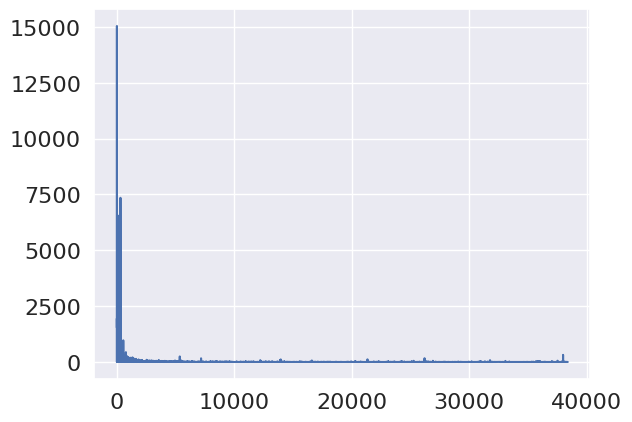

In [43]:
plt.plot(np.bincount(fqdn_cluster["cluster"]))

## t-SNE attempt

### Recalculation

In [44]:
from sklearn.manifold import TSNE

# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(X_all)

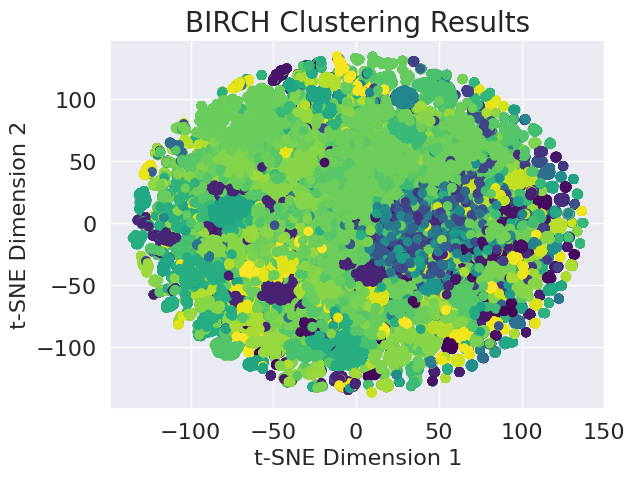

In [45]:
# Create a scatter plot
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap="viridis_r")
plt.title("BIRCH Clustering Results")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

In [46]:
if SAVE_FIGS:
    with open("tsne_reduced_X_all_reproducible.pkl", "wb") as file:
        pickle.dump(reduced_data, file)

### Loading pre-computed data

## UMAP attempt

### Recalculation

In [47]:
import umap.umap_ as umap

# Perform dimensionality reduction using UMAP
umap_t = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
embedding = umap_t.fit_transform(X_all)

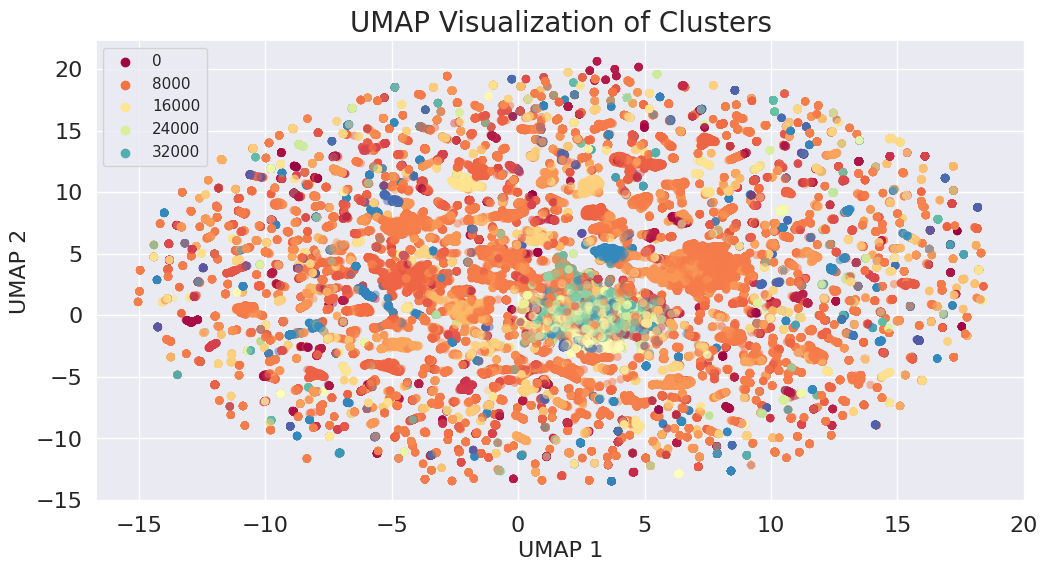

In [48]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=labels,
    palette="Spectral",
    linewidth=0,
    alpha=0.5,
    rasterized=True,  # helps with rendering speed when there are many points
)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP Visualization of Clusters")
plt.show()

In [49]:
if SAVE_FIGS:
    with open("umap_reduced_X_all_reproducible.pkl", "wb") as file:
        pickle.dump(embedding, file)

### Loading pre-computed data

## Histograms

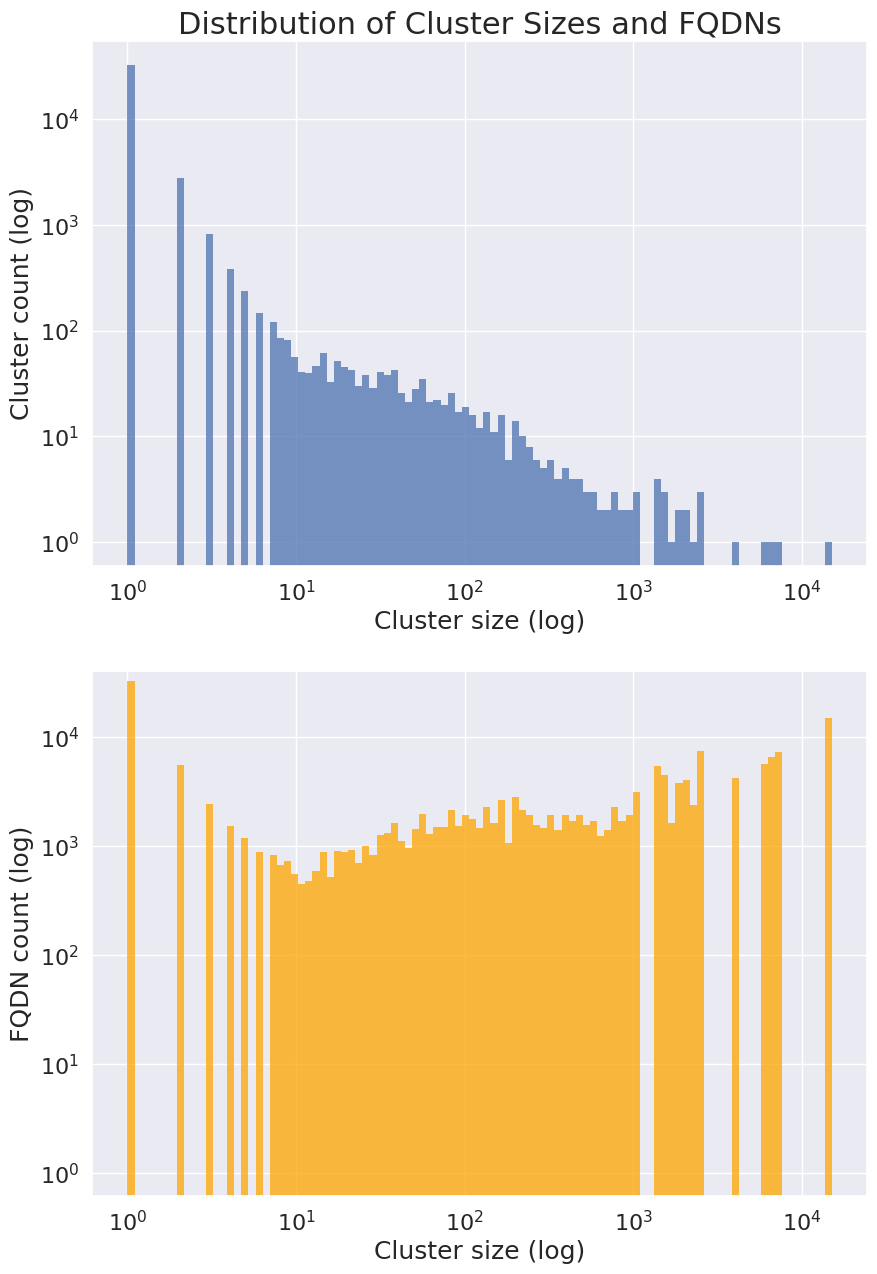

In [50]:
# Set the number of bins to use
num_bins = 100

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 15))

# Create a sequence of log-spaced bin edges
bins_ax = np.logspace(
    0,
    np.log10(max(max(cluster_sizes), max(fqdns_per_cluster_repeated)) + 1),
    num=num_bins,
)

sns.histplot(cluster_sizes, stat="count", bins=bins_ax, log=True, ax=ax1)
ax1.set_xlabel("Cluster size (log)", fontsize=18)
ax1.set_ylabel("Cluster count (log)", fontsize=18)
ax1.set_title("Distribution of Cluster Sizes and FQDNs", fontsize=22)
ax1.set_xscale("log")


sns.histplot(
    fqdns_per_cluster_repeated,
    stat="count",
    bins=bins_ax,
    color="orange",
    log=True,
    ax=ax2,
)
ax2.set_xlabel("Cluster size (log)", fontsize=18)
ax2.set_ylabel("FQDN count (log)", fontsize=18)

ax2.set_xscale("log")
ax2.set_ybound(ax2.get_xbound()[0])


if SAVE_FIGS:
    plt.savefig(
        "visualisations/svg/histogram-overall-log.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/histogram-overall-log.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )

plt.show()

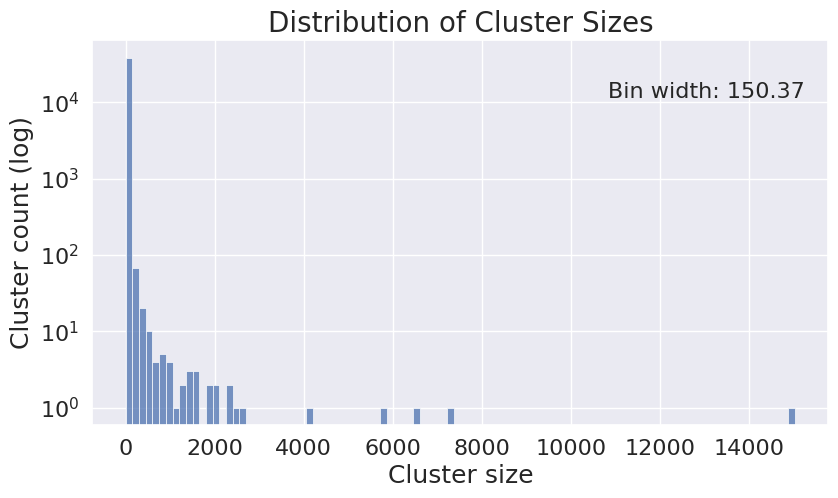

In [51]:
bin_count = 100
bin_width = (cluster_sizes.max() - cluster_sizes.min()) / bin_count

plt.figure(figsize=(9.5, 5))
sns.histplot(cluster_sizes, bins=bin_count, stat="count", log=True)
plt.xlabel("Cluster size", fontsize=18)
plt.ylabel("Cluster count (log)", fontsize=18)
plt.title("Distribution of Cluster Sizes", fontsize=20)
plt.annotate(f"Bin width: {bin_width:.2f}", xy=(0.70, 0.85), xycoords="axes fraction")
if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/histogram-overall-norm.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/histogram-overall-norm.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )


plt.show()

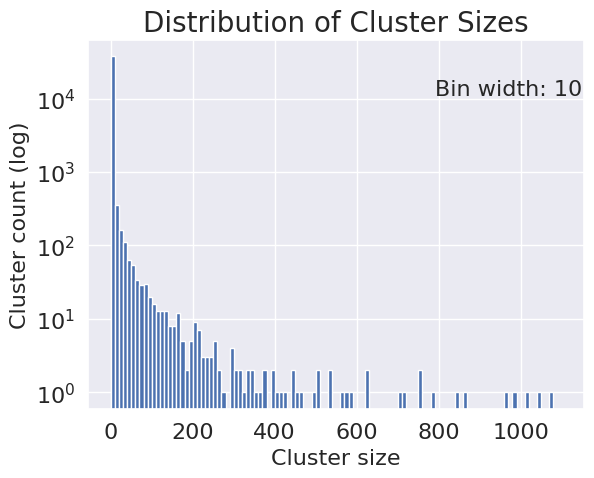

In [52]:
bin_width = 10
bins = np.arange(0, 1101, bin_width)

plt.hist(cluster_sizes, bins=bins, log=True)
plt.xlabel("Cluster size")
plt.ylabel("Cluster count (log)")
plt.title("Distribution of Cluster Sizes")
plt.annotate(f"Bin width: {bin_width}", xy=(0.70, 0.85), xycoords="axes fraction")
if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/histogram-0-1100-sizes.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/histogram-0-1100-sizes.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
plt.show()

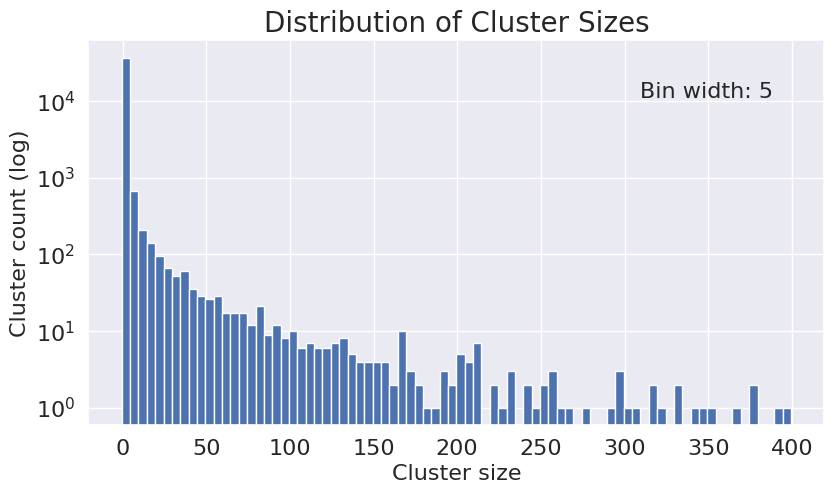

In [53]:
bin_width = 5
bins = np.arange(0, 401, bin_width) - 0.5

plt.figure(figsize=(9.5, 5))

plt.hist(cluster_sizes, bins=bins, log=True)
plt.xlabel("Cluster size")
plt.ylabel("Cluster count (log)")
plt.title("Distribution of Cluster Sizes")
plt.annotate(f"Bin width: {bin_width}", xy=(0.75, 0.85), xycoords="axes fraction")
if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/histogram-0-400-sizes.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/histogram-0-400-sizes.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
plt.show()

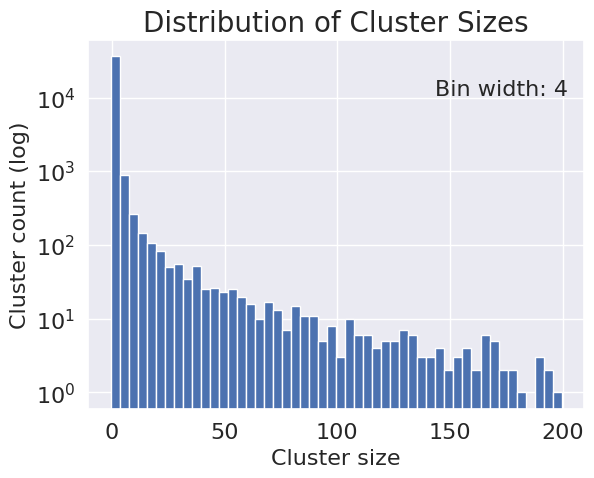

In [54]:
bin_width = 4
bins = np.arange(0, 201, bin_width) - 0.5

plt.hist(cluster_sizes, bins=bins, log=True)
plt.xlabel("Cluster size")
plt.ylabel("Cluster count (log)")
plt.title("Distribution of Cluster Sizes")
plt.annotate(f"Bin width: {bin_width}", xy=(0.70, 0.85), xycoords="axes fraction")
if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/histogram-0-200-sizes.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/histogram-0-200-sizes.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
plt.show()

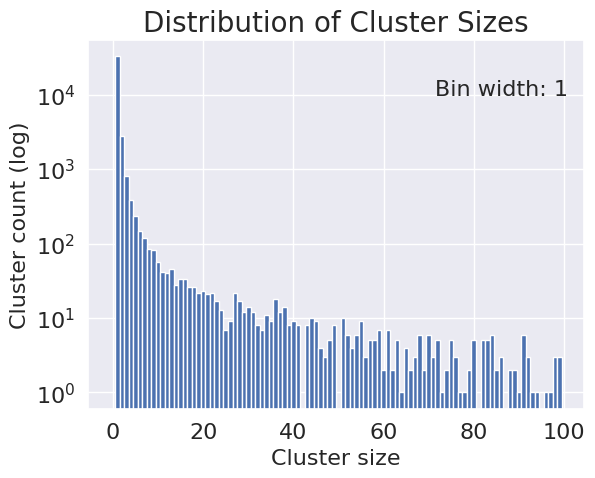

In [55]:
bin_width = 1
bins = np.arange(0, 101, bin_width) - 0.5

plt.hist(cluster_sizes, bins=bins, log=True)
plt.xlabel("Cluster size")
plt.ylabel("Cluster count (log)")
plt.title("Distribution of Cluster Sizes")
plt.annotate(f"Bin width: {bin_width}", xy=(0.70, 0.85), xycoords="axes fraction")
if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/histogram-0-100-sizes.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/histogram-0-100-sizes.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
plt.show()

## Specific cluster ngram analysis

In [56]:
cluster_sizes[cluster_sizes == max(cluster_sizes)]

cluster
5    15038
dtype: int64

In [57]:
def extract_most_frequent_ngrams(fqdns, n=3, top_k=5):
    """
    Extract top_k most frequent n_grams from cluster
    """

    ngrams_counter = Counter()
    for fqdn in fqdns:
        for i in range(len(fqdn) - n + 1):
            ngrams_counter[fqdn[i : i + n]] += 1
    return ngrams_counter.most_common(top_k)


# Analyze a specific cluster, e.g., cluster 0
cluster_fqdns = fqdn_cluster[fqdn_cluster["cluster"] == 5]["FQDN"]
for n in range(1, 10):
    most_frequent_ngrams = extract_most_frequent_ngrams(cluster_fqdns, n)
    print(most_frequent_ngrams)

[('o', 18044), ('e', 17196), ('.', 15334), ('a', 14416), ('r', 14021)]
[('.c', 5403), ('co', 5350), ('om', 4921), ('or', 4785), ('ne', 4099)]
[('com', 4515), ('.co', 4466), ('org', 3665), ('.or', 3618), ('net', 3203)]
[('.com', 4392), ('.org', 3618), ('.net', 3053), ('i.co', 705), ('s.ne', 614)]
[('i.com', 703), ('s.net', 614), ('x.com', 513), ('w.com', 510), ('e.org', 499)]
[('aw.com', 200), ('ow.com', 188), ('law.co', 177), ('ag.com', 153), ('er.net', 141)]
[('law.com', 177), ('mag.com', 119), ('now.com', 78), ('ing.net', 59), ('ing.org', 55)]
[('show.com', 31), ('emag.com', 28), ('museum.o', 27), ('useum.or', 27), ('seum.org', 27)]
[('museum.or', 27), ('useum.org', 27), ('stuff.com', 22), ('family.or', 18), ('amily.org', 18)]


## Boxplots

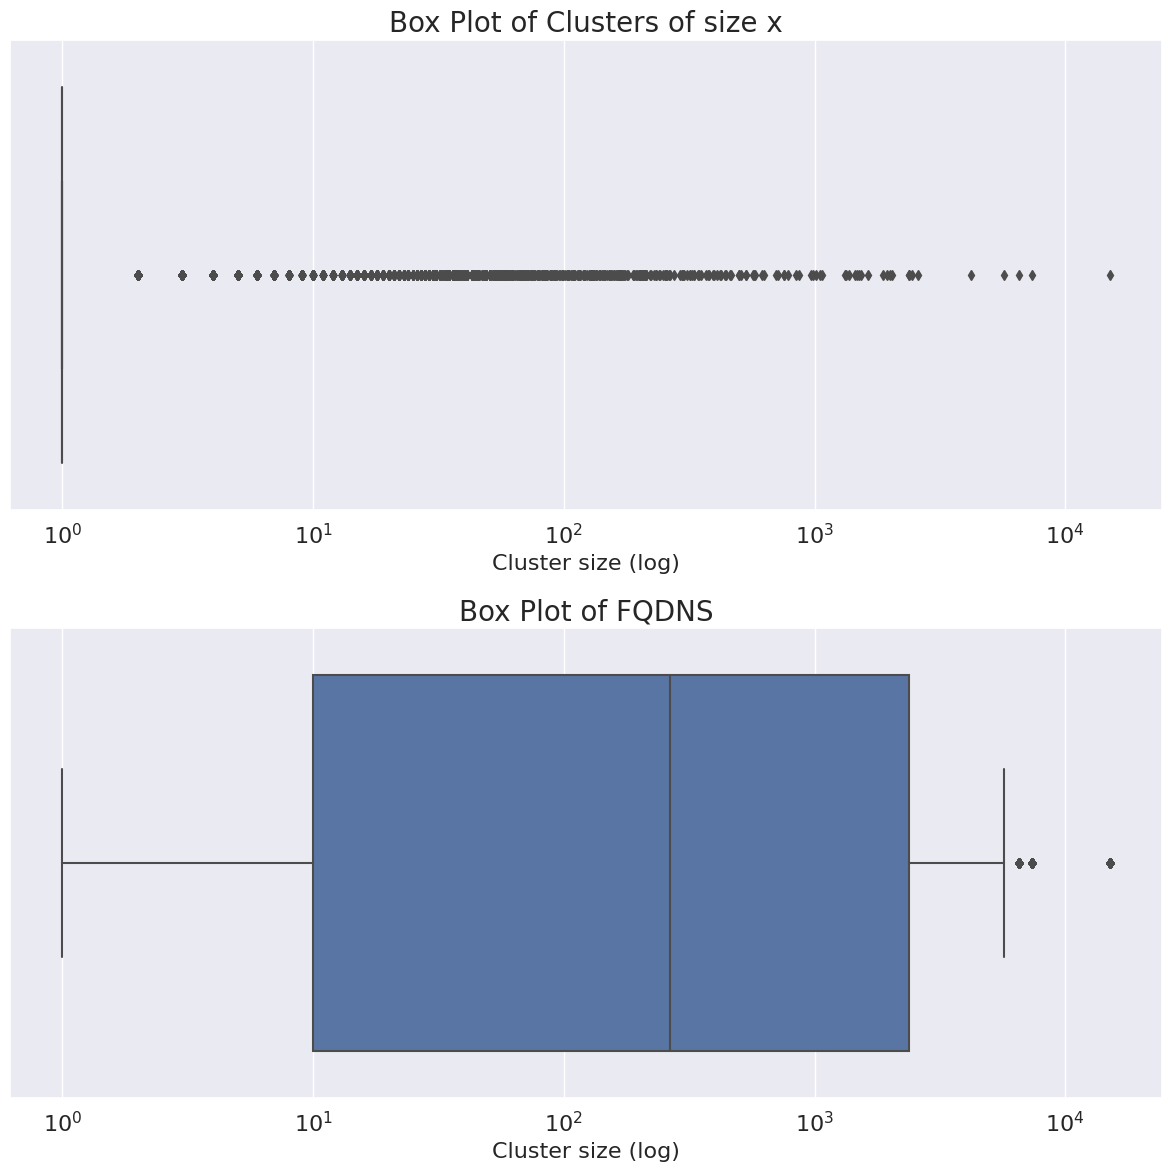

In [58]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 12))

sns.boxplot(x=cluster_sizes, ax=axes[0])
axes[0].set_xlabel("Cluster size (log)")
axes[0].set_title("Box Plot of Clusters of size x")
axes[0].set_xscale("log")

sns.boxplot(x=fqdns_per_cluster_repeated, ax=axes[1])
axes[1].set_xlabel("Cluster size (log)")
axes[1].set_title("Box Plot of FQDNS")
axes[1].set_xscale("log")

plt.tight_layout()

if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/box-overall-log.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/box-overall-log.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )


plt.show()

## Violin plots

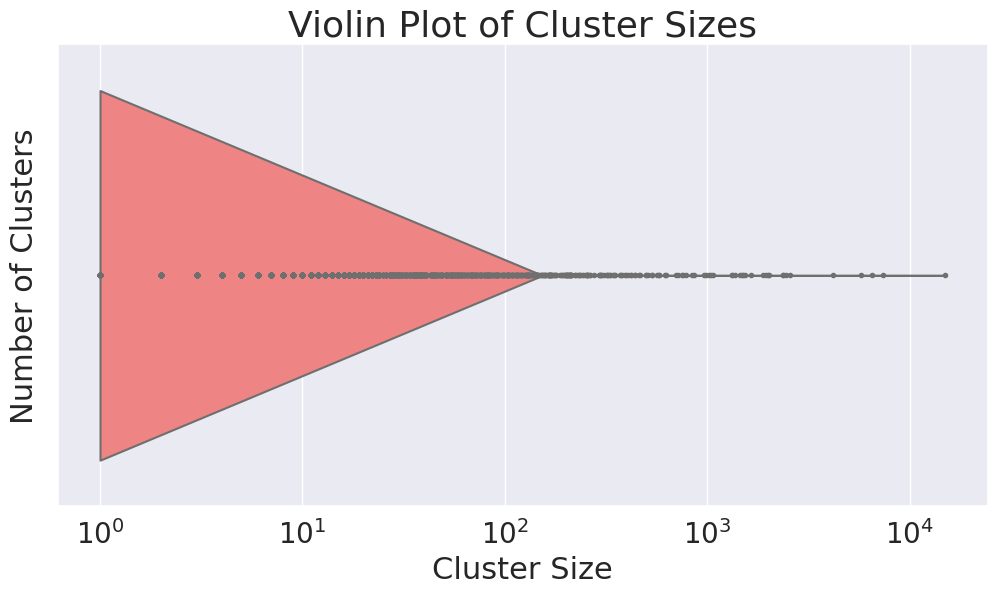

In [59]:
plt.figure(figsize=(12, 6))
ax = sns.violinplot(
    x=cluster_sizes,
    cut=0,
    color="#ff7373",
    inner="points",
)
plt.xlabel("Cluster Size", fontsize=22)
plt.ylabel("Number of Clusters", fontsize=22)
plt.title("Violin Plot of Cluster Sizes", fontsize=26)

ax.set_xscale("log")
ax.tick_params(labelsize=20)

if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/violin-sizes-log.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/violin-sizes-log.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
plt.show()

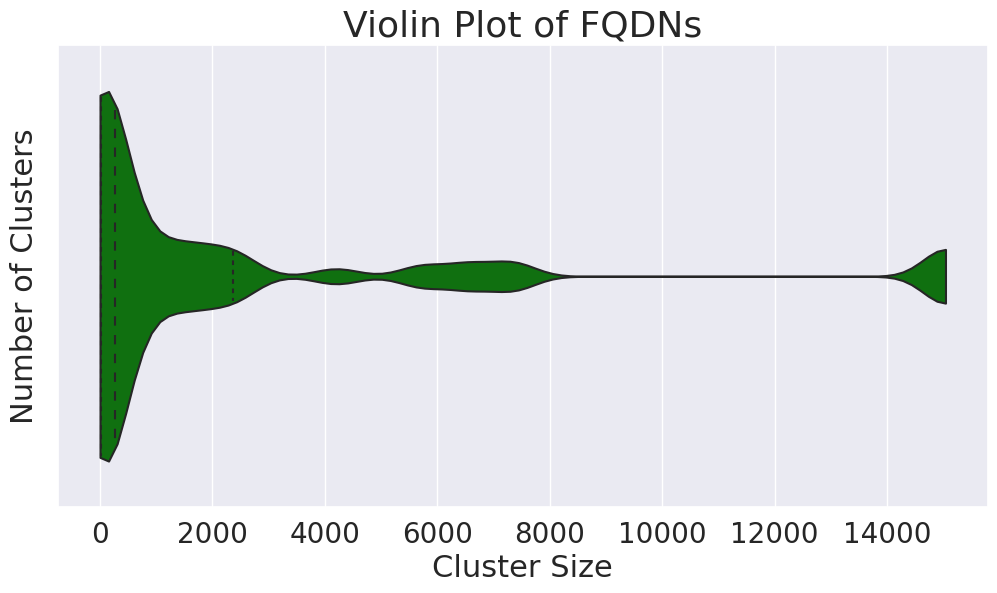

In [60]:
plt.figure(figsize=(12, 6))
ax = sns.violinplot(
    x=fqdns_per_cluster_repeated, cut=0, color="green", inner="quartile", bw="silverman"
)
plt.xlabel("Cluster Size", fontsize=22)
plt.ylabel("Number of Clusters", fontsize=22)
plt.title("Violin Plot of FQDNs", fontsize=26)

ax.tick_params(labelsize=20)

if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/violin-fqdns-norm.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/violin-fqdns-norm.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
plt.show()

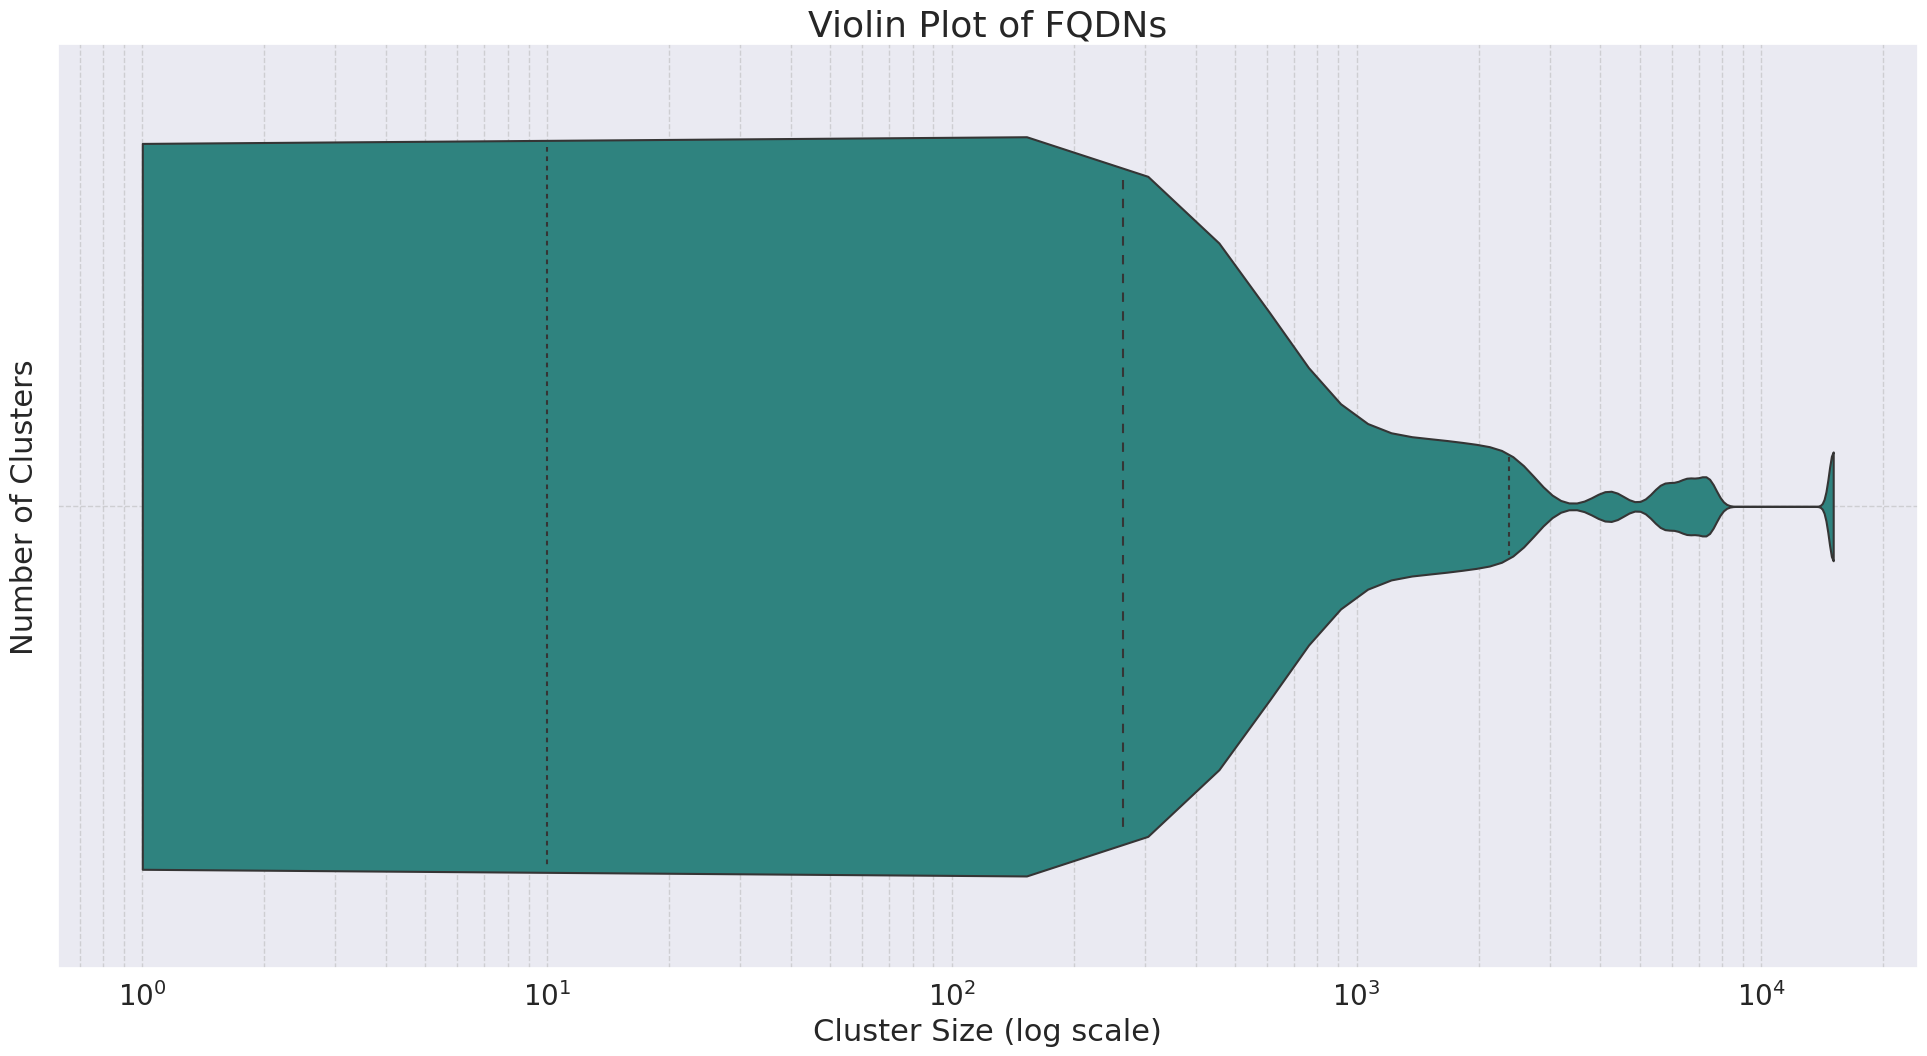

In [61]:
plt.figure(figsize=(24, 12))
ax = sns.violinplot(
    x=fqdns_per_cluster_repeated,
    cut=0,
    palette="viridis",
    inner="quartile",
)
plt.xlabel("Cluster Size (log scale)", fontsize=22)
plt.ylabel("Number of Clusters", fontsize=22)
plt.title("Violin Plot of FQDNs", fontsize=26)

ax.set_xscale("log")
ax.tick_params(labelsize=20)

# Add a logarithmic grid with light grey color
ax.grid(True, which="both", linestyle="--", alpha=0.5, color=(0.7, 0.7, 0.7))

if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/violin-fqdns-log.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/violin-fqdns-log.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
plt.show()

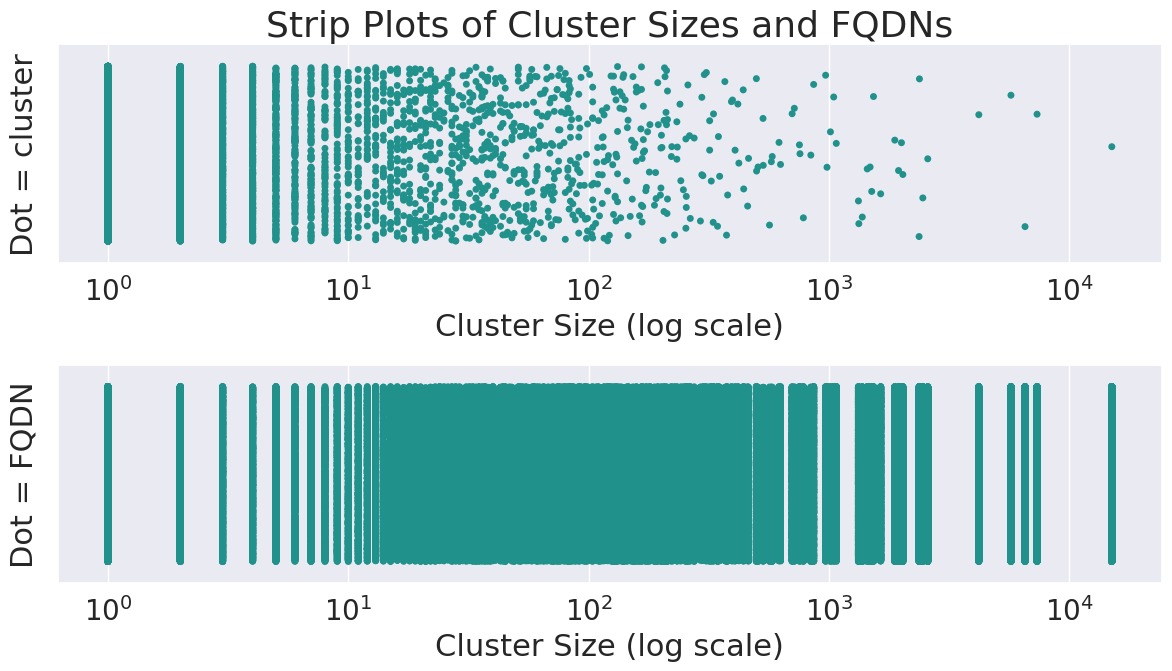

In [62]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 7))

sns.stripplot(x=cluster_sizes, palette="viridis", jitter=0.4, ax=ax1)
ax1.set_xlabel("Cluster Size (log scale)", fontsize=22)
ax1.set_ylabel("Dot = cluster", fontsize=22)
ax1.set_title("Strip Plots of Cluster Sizes and FQDNs", fontsize=26)
ax1.set_xscale("log")
ax1.tick_params(labelsize=20)

sns.stripplot(x=fqdns_per_cluster_repeated, palette="viridis", jitter=0.4, ax=ax2)
ax2.set_xlabel("Cluster Size (log scale)", fontsize=22)
ax2.set_ylabel("Dot = FQDN", fontsize=22)
ax2.set_xscale("log")
ax2.tick_params(labelsize=20)

plt.tight_layout()

if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/strip-overall-log.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/strip-overall-log.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
plt.show()

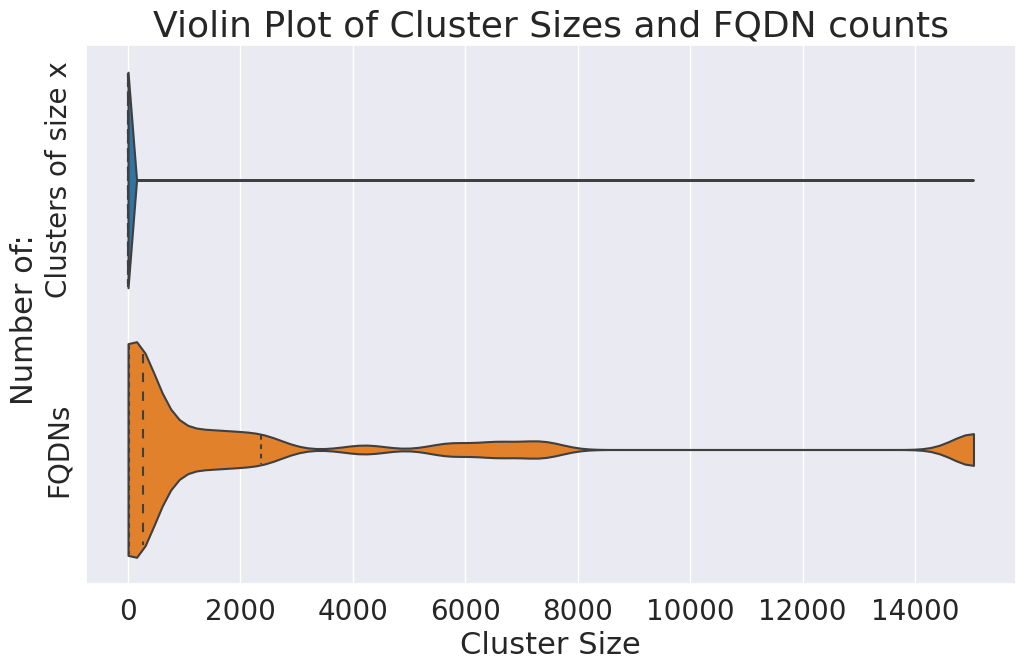

In [63]:
plt.figure(figsize=(12, 7))
ax = sns.violinplot(
    data=hue_violin_data,
    x="value",
    y="category_val",
    cut=0,
    scale="width",
    inner="quartile",
    palette="tab10",
)
plt.xlabel("Cluster Size", fontsize=22)
plt.ylabel("Number of: ", fontsize=22)
plt.title("Violin Plot of Cluster Sizes and FQDN counts", fontsize=26)

ax.tick_params(labelsize=20)
ax.set_yticklabels(["Clusters of size x", "FQDNs"], rotation=90, va="center")


if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/violin-overall-norm.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/violin-overall-norm.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
plt.show()

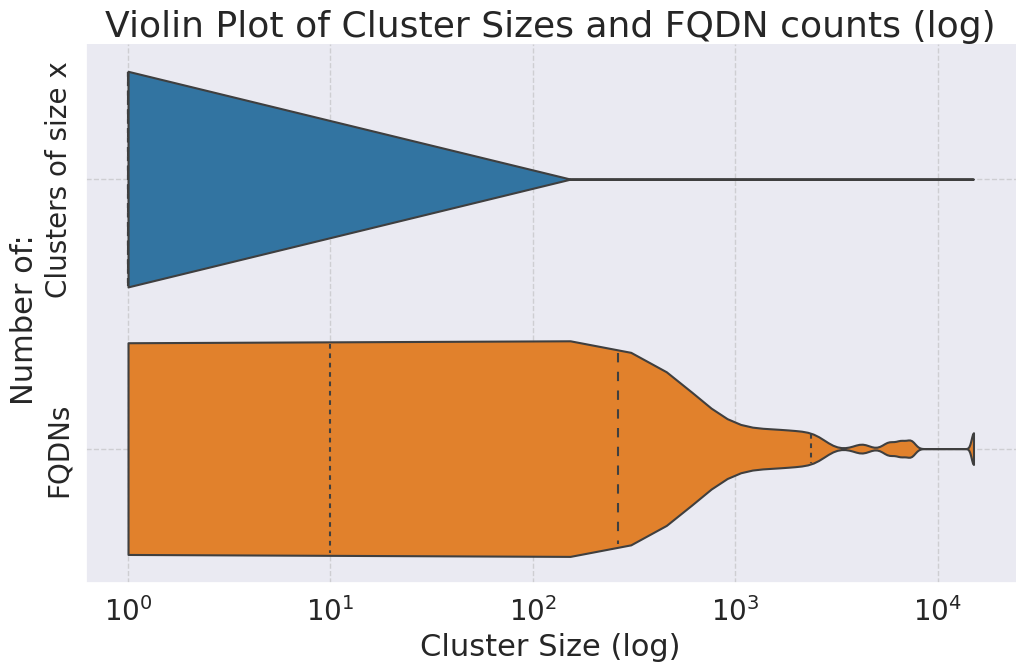

In [64]:
plt.figure(figsize=(12, 7))
ax = sns.violinplot(
    data=hue_violin_data,
    x="value",
    y="category_val",
    cut=0,
    scale="width",
    palette="tab10",
    inner="quartile",
)
plt.xlabel("Cluster Size (log)", fontsize=22)
plt.ylabel("Number of: ", fontsize=22)
plt.title("Violin Plot of Cluster Sizes and FQDN counts (log)", fontsize=26)

ax.set_xscale("log")
ax.tick_params(labelsize=20)

ax.set_yticklabels(["Clusters of size x", "FQDNs"], rotation=90, va="center")

ax.grid(True, which="major", linestyle="--", alpha=0.5, color=(0.7, 0.7, 0.7))

sns.despine()

if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/violin-overall-log.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/violin-overall-log.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
plt.show()

## Bubble plot

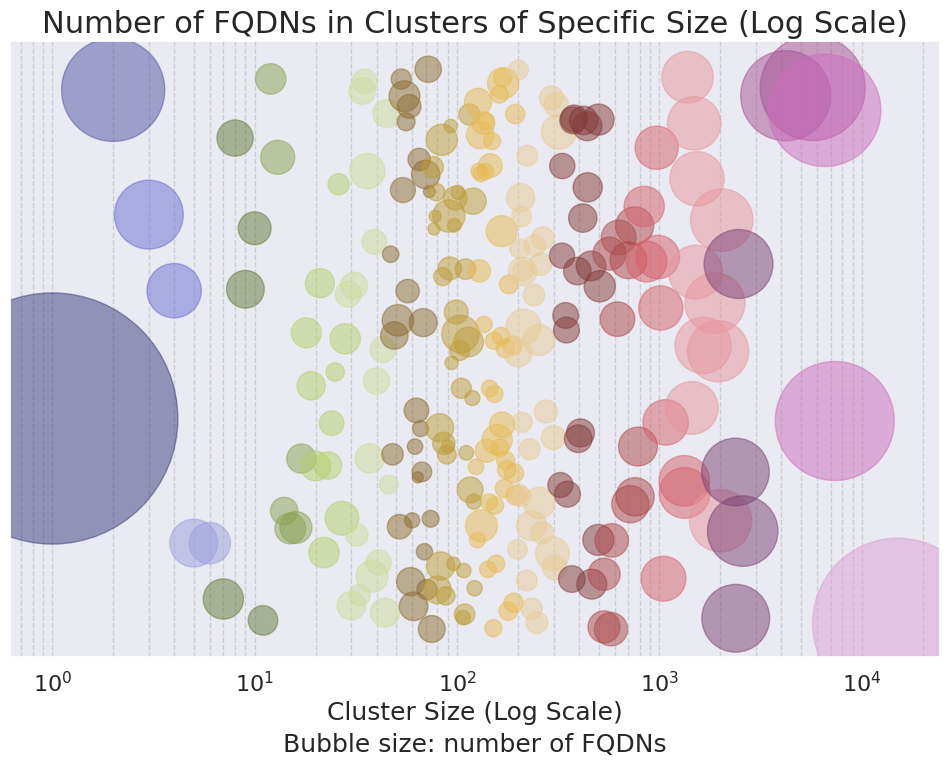

In [65]:
# Bubble plot
cluster_size_counts = fqdns_per_cluster.sort_index()
bubble_sizes = cluster_size_counts.values  # Adjust the scaling factor as needed

# Generate random y-coordinates within a small range
np.random.seed(42)
random_y_coords = np.random.uniform(-0.1, 0.1, len(cluster_size_counts))

# Normalize x-coordinates for colormap and apply log transformation
log_min = np.log10(cluster_size_counts.index.min())
log_max = np.log10(cluster_size_counts.index.max())
log_x_coords = (np.log10(cluster_size_counts.index) - log_min) / (log_max - log_min)


colormap = cm.get_cmap("tab20b")
colors = colormap(log_x_coords)

plt.figure(figsize=(12, 8))

plt.scatter(
    cluster_size_counts.index,
    random_y_coords,
    s=bubble_sizes,
    alpha=0.5,
    c=colors,
)
plt.xlabel("Cluster Size (Log Scale)", fontsize=18)
plt.title("Number of FQDNs in Clusters of Specific Size (Log Scale)", fontsize=22)
plt.gca().axes.get_yaxis().set_visible(False)
plt.xscale("log")
plt.grid(True, which="both", linestyle="--", alpha=0.5, color=(0.7, 0.7, 0.7))

plt.annotate(
    "Bubble size: number of FQDNs",
    xy=(0.5, -0.123),
    xycoords="axes fraction",
    fontsize=18,
    ha="center",
    va="top",
)

if SAVE_FIGS:

    plt.savefig(
        "visualisations/svg/bubble-overall-log.svg",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )
    plt.savefig(
        "visualisations/pdf/bubble-overall-log.pdf",
        bbox_inches="tight",
        pad_inches=0,
        dpi=600,
    )

plt.show()

# Incremental model training example

## First increment

In [66]:
np.random.seed(42)

random_indices = np.random.choice(urls_df.shape[0], size=20000, replace=False)

urls_df_example = urls_df.iloc[random_indices, :]
urls_df_example

,url
536448,http://37.49.226.178/deusbins/deus.sh4
40630,medical-dictionary.thefreedictionary.com/Galt+...
630496,www.jscape.com/sshfactory/
426724,http://www.wsnc.org.au/component/jcalpro/view/983
184034,virtualtourist.com/travel/North_America/Canada...
...,...
924,http://www.honarcinema.com/index.php?option=co...
459670,hollywood.com/celebrity/1113944/Tim_Burton
192981,http://3cf.ru/2015/07/21/otriad-korablei-vmf-r...
502778,http://kenh14.vn/musik/cac-thi-sinh-giong-hat-...


In [67]:
urls_extracted_example = extract_features(urls_df_example)

In [68]:
urls_extracted_example.shape[0]

11282

In [69]:
urls_matrix_example = transform_features(urls_extracted_example, random_state=12)

In [70]:
tfidf_lsas_example, explained_variances_example, vectorisers_example = preprocess_tfidf(
    urls_extracted_example,
    ["domainTLD", "subdomain"],
    [(5, 8), (2, 5)],
    [138, 121],
    random_state=123,
)

In [71]:
X_all_nonstandardised_example = np.hstack([urls_matrix_example] + tfidf_lsas_example)

In [72]:
X_all_example = standardise_features(X_all_nonstandardised_example)

In [73]:
X_all_example.shape

(11282, 271)

In [74]:
birch = train_BIRCH(X_all_example, 265, 4.07)
# Get the cluster labels for each data point
labels = birch.labels_

metrics = evaluate_model(X_all_example, labels)

# Print the scores
print("Silhouette Score: ", metrics[0])
print("Calinski-Harabasz Index: ", metrics[1])
print("Davies-Bouldin Index: ", metrics[2])

print(f"Num of clusters: {len([node for node in birch.subcluster_centers_])}")

Silhouette Score:  0.14818980724476222
Calinski-Harabasz Index:  80.28803683763623
Davies-Bouldin Index:  0.43282629449960863
Num of clusters: 3259


## Second increment

In [75]:
np.random.seed(44)

random_indices = np.random.choice(urls_df.shape[0], size=20000, replace=False)

urls_df_example2 = urls_df.iloc[random_indices, :]

In [76]:
urls_extracted_example2 = extract_features(urls_df_example2)

In [77]:
urls_extracted_example2.shape[0]

11250

In [78]:
urls_matrix_example2 = transform_features(urls_extracted_example2, random_state=12)

In [79]:
(
    tfidf_lsas_example2,
    explained_variances_example2,
    vectorisers_example2,
) = increment_preprocess_tfidf(
    df=urls_extracted_example2,
    n_components=[138, 121],
    fitted_vectorisers=vectorisers_example,
    random_state=31,
)

In [80]:
X_all_nonstandardised_example2 = np.hstack(
    [np.vstack((urls_matrix_example, urls_matrix_example2))] + tfidf_lsas_example2
)

In [81]:
X_all_example2 = standardise_features(X_all_nonstandardised_example2)

In [82]:
X_all_example2.shape

(22532, 271)

In [83]:
birch = train_BIRCH(X_all_example2, 265, 4.07)

# Get the cluster labels for each data point
labels_example2 = birch.labels_

metrics = evaluate_model(X_all_example2, labels_example2)

# Print the scores
print("Silhouette Score: ", metrics[0])
print("Calinski-Harabasz Index: ", metrics[1])
print("Davies-Bouldin Index: ", metrics[2])

print(f"Num of clusters: {len([node for node in birch.subcluster_centers_])}")

Silhouette Score:  0.18012757870661592
Calinski-Harabasz Index:  107.77712699975794
Davies-Bouldin Index:  0.48022989210404976
Num of clusters: 5311


# Time testing

To run time testing start with a fresh core

In [ ]:
def reload_df_time():
    """
    Reload dataset used for time and memory measurements
    """
    df_time1 = load_data("datasets/kaggle_siddharta_malicious_benign.csv")
    df_time2 = load_data("datasets/openphis_phishingURLs.csv")
    df_time3 = load_data("datasets/advisor-sent-data.csv")

    df_time = pd.concat((df_time1, df_time2, df_time3), axis=0)

    del df_time1
    del df_time2
    del df_time3

    df_time = clean_data(extract_FQDNs(df_time))

    return df_time

In [ ]:
def run_test_example(df_time_sample):
    """
    Run single time and memory test
    """

    df_time_extracted = extract_features(df_time_sample)

    df_time_matrix = transform_features(df_time_extracted, random_state=12)

    tfidf_lsas_time, _, _ = preprocess_tfidf(
        df_time_extracted,
        ["domainTLD", "subdomain"],
        [(5, 8), (2, 5)],
        [138, 121],
        random_state=123,
    )

    X_all_nonstandardised_time = np.hstack([df_time_matrix] + tfidf_lsas_time)

    X_all_time = standardise_features(X_all_nonstandardised_time)

    birch = train_BIRCH(X_all_time, 265, 4.07)

    _ = birch.labels_

    process = psutil.Process()
    memory_usage = process.memory_info().rss

    print(f"Run with df of shape {df_time_sample.shape}; used {memory_usage} memory")

In [ ]:
def start_process(process):
    """
    Start and join a process
    """

    # Start the process
    process.start()

    # Wait for the process to finish
    process.join()

In [ ]:
sample_sizes = [1, 10, 100, 1000, 10000, 100000, 200000]

# Measure time and memory resources of runs over multiple sample sizes
for n in sample_sizes:

    df_time = reload_df_time()

    np.random.seed(42)

    random_indices = np.random.choice(df_time.shape[0], size=n, replace=False)

    df_time_sample = df_time.iloc[random_indices, :]

    del df_time

    # Create a new process for each run
    process = mp.Process(target=run_test_example, args=(df_time_sample,))

    %time start_process(process)

# Hyperparamter tuning

## Handwritten LSA selection parameter tuning

Comment next block and uncomment following code if you do not have the pre-comptued data - Execution takes long

### Load pre-computed data

In [84]:
# Open the file in binary mode
with open("visualisations/domain_n_components_search.pkl", "rb") as file:
    components_variance_time_d = pickle.load(file)

with open("visualisations/subdomain_n_components_search.pkl", "rb") as file:
    components_variance_time_s = pickle.load(file)

### Recompute data

### Visualisation

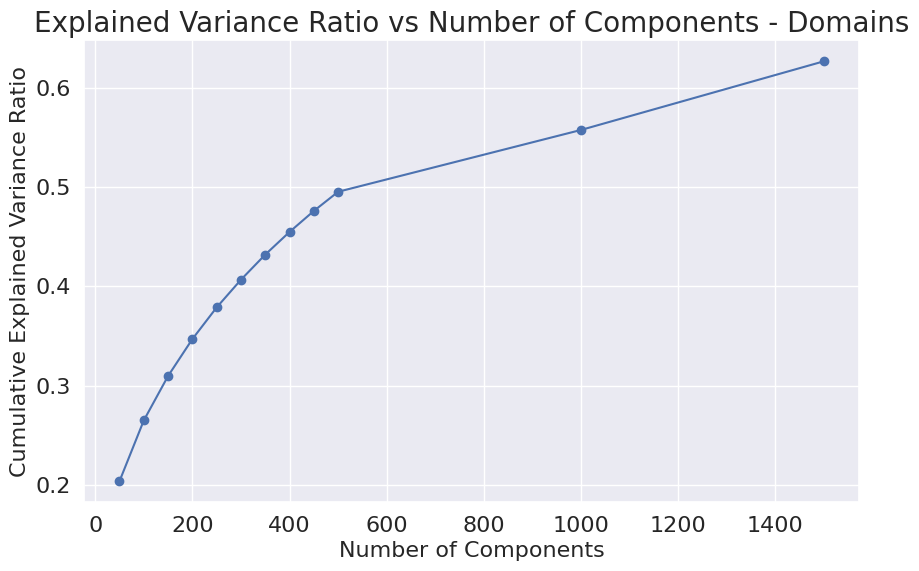

In [85]:
# Plot the cumulative explained variance ratio as a function of the number of components
plt.figure(figsize=(10, 6))
plt.plot(
    components_variance_time_d["n_components"],
    components_variance_time_d["explained_variance"],
    marker="o",
)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Explained Variance Ratio vs Number of Components - Domains")
plt.show()

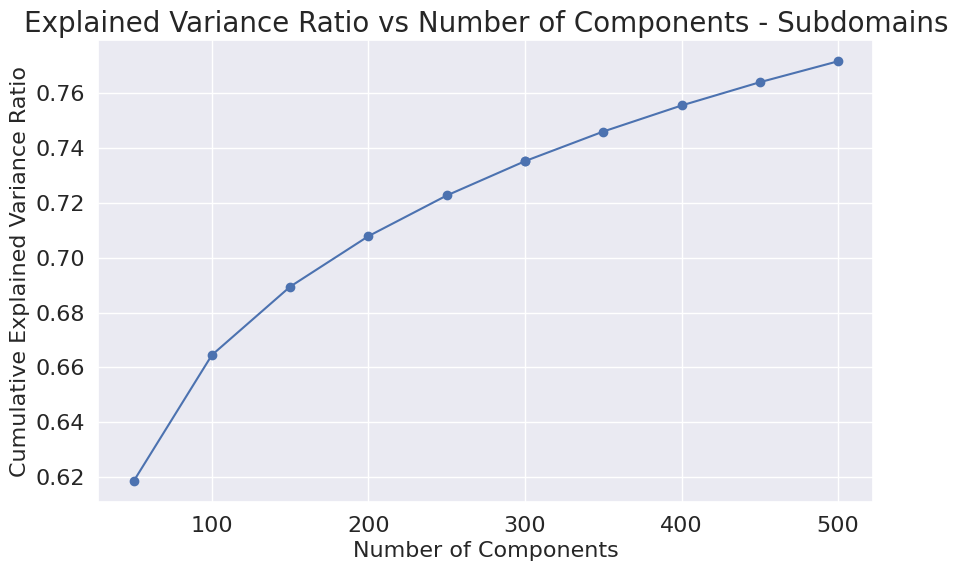

In [86]:
# Plot the cumulative explained variance ratio as a function of the number of components
plt.figure(figsize=(10, 6))
plt.plot(
    components_variance_time_s["n_components"],
    components_variance_time_s["explained_variance"],
    marker="o",
)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Explained Variance Ratio vs Number of Components - Subdomains")
plt.show()

## Optuna tuning

In [ ]:
import gc


def objective(trial):
    # SETUP

    # BIRCH hyperparameters
    branching_factor = trial.suggest_int("branching_factor", 5, 300)
    threshold = trial.suggest_float("threshold", 0.05, 5)

    # Column selection
    ## Trial suggest
    columns_selected = trial.suggest_categorical(
        "columns_selected",
        ["domainsubdomain", "domainsubdomainTLD", "domainTLDtogether_subdomain"],
    )

    ## Options for selection
    columns_options = [
        ["domain", "subdomain"],
        ["domain", "subdomain", "TLD"],
        ["domainTLD", "subdomain"],
    ]

    ## Columns list creation
    if columns_selected == "domainsubdomain":
        columns = columns_options[0]
    elif columns_selected == "domainsubdomainTLD":
        columns = columns_options[1]
    elif columns_selected == "domainTLDtogether_subdomain":
        columns = columns_options[2]

    # Ngram ranges for TF-IDF
    ## Trial suggests
    ngram_domain_or_domainTLD_low = trial.suggest_int(
        "ngram_domain_or_domainTLD_low", 1, 5
    )
    ngram_domain_or_domainTLD_high = trial.suggest_int(
        "ngram_domain_or_domainTLD_high", ngram_domain_or_domainTLD_low, 10
    )

    ngram_subdomain_low = trial.suggest_int("ngram_subdomain_low", 1, 5)
    ngram_subdomain_high = trial.suggest_int(
        "ngram_subdomain_high", ngram_subdomain_low, 10
    )

    ngram_tld_low = trial.suggest_int("ngram_tld_low", 1, 5)
    ngram_tld_high = trial.suggest_int("ngram_tld_high", ngram_tld_low, 10)

    ## Ngram range creation
    ngram_domain_or_domainTLD_range = (
        ngram_domain_or_domainTLD_low,
        ngram_domain_or_domainTLD_high,
    )
    ngram_subdomain_range = (ngram_subdomain_low, ngram_subdomain_high)
    ngram_tld_range = (ngram_tld_low, ngram_tld_high)

    ## Ngrams list
    ngram_ranges = [ngram_domain_or_domainTLD_range, ngram_subdomain_range]

    if len(columns) == 3:
        ngram_ranges.append(ngram_tld_range)

    # Number of components for TruncatedSVD
    n_components_domain_or_domainTLD = trial.suggest_int(
        "n_components_domain_or_domainTLD", 5, 400
    )
    n_components_subdomain = trial.suggest_int("n_components_subdomain", 5, 400)
    n_components_tld = trial.suggest_int("n_components_tld", 5, 300)

    n_components = [n_components_domain_or_domainTLD, n_components_subdomain]

    if len(columns) == 3:
        n_components.append(n_components_tld)

    # EXECUTION
    gc.disable()

    start_tfidf = time.thread_time_ns()

    tfidf_lsas = preprocess_tfidf(
        columns=columns,
        ngram_ranges=ngram_ranges,
        n_components=n_components,
        df=urls_extracted_df,
    )

    # For optuna testing purposes
    # tfidf_lsas = preprocess_tfidf(
    #     columns=["subdomain"],
    #     ngram_ranges=[(1,1)],
    #     n_components=[5],
    #     df=urls_extracted_df.iloc[:, 0:40000],
    # )

    X = np.hstack([urls_matrix[0:40000]] + tfidf_lsas)

    end_tfidf = time.thread_time_ns()

    start_birch = time.thread_time_ns()

    birch = train_BIRCH(X, branching_factor=branching_factor, threshold=threshold)

    end_birch = time.thread_time_ns()

    gc.enable()

    # Calculate time
    birch_time = (end_birch - start_birch) / 1e9
    tfidf_time = (end_tfidf - start_tfidf) / 1e9
    all_time = birch_time + tfidf_time

    trial.set_user_attr("tfidf_time", tfidf_time)
    trial.set_user_attr("birch_time", birch_time)
    trial.set_user_attr("all_time", all_time)

    labels = birch.labels_
    X_sample, labels_sample = subsample(X, 3000, 24, labels)

    num_of_clusters = len(np.bincount(labels))
    trial.set_user_attr("num_of_clusters", num_of_clusters)

    metrics = evaluate_model(X_sample, labels_sample)

    trial.set_user_attr("silhouette", metrics[0])
    trial.set_user_attr("calinski_harabasz", metrics[1])
    trial.set_user_attr("davies_bouldin", metrics[2])

    # Combine silhouette with time penalty as score

    try:
        score = metrics[0] + log(-0.2 * all_time + 1799) - 7.51
    except ValueError:
        score = -(2**25)

    return score

In [ ]:
import sys

original_stdout = sys.stdout
original_stderr = sys.stderr

sys.stdout = open("output.log", "w")
sys.stderr = open("error.log", "w")

# Update database URL to fit your database
with open(".hidden/pgdb_optuna_storage_url.txt", "r") as file:
    DATABASE_URL = file.read().rstrip()

study = optuna.create_study(
    storage=DATABASE_URL,
    direction="maximize",
    study_name="birch_maximisation_study_test",
    load_if_exists=True,
)

study.optimize(objective, n_trials=20, n_jobs=20)

In [ ]:
sys.stdout = original_stdout
sys.stderr = original_stderr

In [ ]:
# load the test_study from the database
test_study = optuna.load_study(
    study_name="birch_maximisation_study", storage="sqlite:///optimalisation.db"
)

In [ ]:
# print the trial results
for trial in test_study.trials:
    print(
        f'Trial {trial.number}: score={trial.value}, silhouette={trial.user_attrs.get("silhouette")}, time={trial.user_attrs.get("all_time")}'
    )

trial = test_study.best_trial

print(
    f'Trial {trial.number}: score={trial.value}, silhouette={trial.user_attrs.get("silhouette")}, time={trial.user_attrs.get("all_time")}'
)

In [ ]:
for trial in test_study.trials:
    print(trial.user_attrs.get("silhouette"))

### Trial exploration


In [ ]:
from optuna.visualization.matplotlib import (
    plot_contour,
    plot_edf,
    plot_intermediate_values,
    plot_optimization_history,
    plot_parallel_coordinate,
    plot_param_importances,
    plot_slice,
)

In [ ]:
plot_optimization_history(test_study)

In [ ]:
plot_parallel_coordinate(test_study)

In [ ]:
plot_contour()